In [1]:
import sncosmo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sncosmo.salt2utils import BicubicInterpolator
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
import pickle as pk
from matplotlib.backends.backend_pdf import PdfPages
import os 
from matplotlib.offsetbox import AnchoredText
import astropy.constants as const
import astropy.units as u
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

sns.set_style("whitegrid", {'axes.grid':'False','xtick.bottom': True,'ytick.left': True})

params = {"text.usetex" : True,'font.size': 20, 'font.family':'serif', 'font.serif':'Computer Modern'}
plt.rcParams.update(params)

H_ERG_S = const.h.cgs.value
C_AA_PER_S = const.c.to(u.AA / u.s).value
HC_ERG_AA = H_ERG_S * C_AA_PER_S
SCALE_FACTOR = 1e-12

In [2]:
class ScalarFormatterClass1(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"

## Comentários

In [3]:
#

## Recuperando curvas de luz

In [4]:
path="./light_curves/Pantheon/Pantheon_HST_TEXT/"

In [5]:
l=[]
with open(path+"Pantheon_HST_TEXT.README",'r') as f:
    for line in f:
        l.append(line.split())

In [6]:
sne_pass_cut=[l[8:35][i][0] for i in range(0,len(l[8:35]))]

In [7]:
len(sne_pass_cut)

27

## Decodificando filtros

No SNANA diz que a tramissividade dos filtros está em unidade de fraçao de fótons, que é já é o padrão do SNCOSMO

In [8]:
filters_dict={"candles":{"a":"ACS_WFC_F435W",
                         "b":"ACS_WFC_F475W",
                         "c":"ACS_WFC_F606W",
                         "d":"ACS_WFC_F625W",
                         "e":"ACS_WFC_F775W",
                         "f":"ACS_WFC_F814W",
                         "g":"ACS_WFC_F850LP",
                         "h":"WFC3_UVIS_F225W",
                         "i":"WFC3_UVIS_F275W",
                         "j":"WFC3_UVIS_F336W",
                         "k":"WFC3_UVIS_F390W",
                         "l":"WFC3_UVIS_F350LP",
                         "m":"WFC3_IR_F105W",
                         "n":"WFC3_IR_F110W",
                         "o":"WFC3_IR_F125W",
                         "p":"WFC3_IR_F140W",
                         "q":"WFC3_IR_F160W",
                         "r":"WFC3_IR_F098M",
                         "s":"WFC3_IR_F127M",
                         "t":"WFC3_IR_F139M",
                         "u":"WFC3_IR_F153M"},
                "goods":{"v":"F110W_NIC2",
                         "w":"F160W_NIC2",
                         "x":"F606W_ACS",
                         "y":"F675W_WFPC2",
                         "z":"F775W_ACS",
                         "A":"F814W_WFPC2",
                         "B":"F850LP_ACS",
                          "C":"F110W_NIC2",
                          "D":"F775W_ACS",
                          "E":"F850LP_ACS",
                          "F":"NIC3.F110r", # n tem .dat
                          "G":"NIC3.F160r", # n tem .dat
                          "H":"wfpc2.f814w.092003r",
                          "I":"F110W_NIC2",
                          "J":"newh_nirc2",
                          "K":"F775W_ACS",
                          "L":"F850LP_ACS"}}

In [9]:
path_f_can="/home/cassia/SNANA/snroot/filters/PS1/Pantheon/HST/HST_Candles/"
path_f_goods="/home/cassia/SNANA/snroot/filters/PS1/Pantheon/HST/HST_GOODS/"

## Registrando filtros e criando sistema de magnitude composto

In [10]:
ab = sncosmo.get_magsystem('ab')

In [11]:
for surv in filters_dict:
    if surv=="candles":
        for filt in filters_dict[surv].values():
            wave = pd.read_csv(path_f_can+filt+".dat",header=None,sep="\s+",comment="#")[0].values
            trans = pd.read_csv(path_f_can+filt+".dat",header=None,sep="\s+",comment="#")[1].values
            band = sncosmo.Bandpass(wave, trans, name=surv+'_'+filt,trim_level=0.05)
        
            sncosmo.registry.register(band,force=True)
    if surv=="goods":
        for filt in filters_dict[surv].values():
            if filt in ["NIC3.F110r","NIC3.F160r"]:
                wave = pd.read_csv(path_f_goods+filt,header=None,sep="\s+",comment="#")[0].values
                trans = pd.read_csv(path_f_goods+filt,header=None,sep="\s+",comment="#")[1].values
                band = sncosmo.Bandpass(wave, trans, name=surv+'_'+filt,trim_level=0.05)
        
                sncosmo.registry.register(band,force=True)
            else:
                wave = pd.read_csv(path_f_goods+filt+".dat",header=None,sep="\s+",comment="#")[0].values
                trans = pd.read_csv(path_f_goods+filt+".dat",header=None,sep="\s+",comment="#")[1].values
                band = sncosmo.Bandpass(wave, trans, name=surv+'_'+filt,trim_level=0.05)
        
                sncosmo.registry.register(band,force=True)

In [12]:
magsystem = {"candles":{"candles_ACS_WFC_F435W":('ab',0.),
                      "candles_ACS_WFC_F475W":('ab',0.),
                      "candles_ACS_WFC_F606W":('ab',0.),
                      "candles_ACS_WFC_F625W":('ab',0.),
                      "candles_ACS_WFC_F775W":('ab',0.),
                      "candles_ACS_WFC_F775W":('ab',0.),
                      "candles_ACS_WFC_F814W":('ab',0.),
                      "candles_ACS_WFC_F850LP":('ab',0.),
                      "candles_WFC3_UVIS_F225W":('ab',0.),
                      "candles_WFC3_UVIS_F275W":('ab',0.),
                      "candles_WFC3_UVIS_F336W":('ab',0.),
                      "candles_WFC3_UVIS_F390W":('ab',0.),
                      "candles_WFC3_UVIS_F350LP":('ab',0.),
                      "candles_WFC3_IR_F105W":('ab',0.),
                      "candles_WFC3_IR_F110W":('ab',0.),
                      "candles_WFC3_IR_F125W":('ab',0.),
                      "candles_WFC3_IR_F140W":('ab',0.),
                      "candles_WFC3_IR_F160W":('ab',0.),
                      "candles_WFC3_IR_F098M":('ab',0.),
                      "candles_WFC3_IR_F127M":('ab',0.),
                      "candles_WFC3_IR_F139M":('ab',0.),
                      "candles_WFC3_IR_F153M":('ab',0.)},
             "goods":{"goods_F110W_NIC2":('ab',0.),
                      "goods_F160W_NIC2":('ab',0.),
                      "goods_F606W_ACS":('ab',0.),
                      "goods_F675W_WFPC2":('ab',0.),
                      "goods_F775W_ACS":('ab',0.),
                      "goods_F814W_WFPC2":('ab',0.),
                      "goods_F850LP_ACS":('ab',0.),
                      "goods_NIC3.F110r":('ab',0.),
                      "goods_NIC3.F160r":('ab',0.),
                      "goods_wfpc2.f814w.092003r":('ab',0.),
                      "goods_newh_nirc2":('ab',0.)}}

## Criando modelo EXP

In [13]:
class EXP_LC(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2']
    param_names_latex = ['x_0', 'x_1', 'x_2']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, name='EXP', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0.T)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1.T)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2.T)

        self._parameters = np.array([1, 0, 0])  # initial guess
        

    def _flux(self, phase, wave):
        
        x0, x1, x2= self._parameters
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave))

In [14]:
gridx2 = np.linspace(-10, 50, 50+10+1, dtype=int)
gridy2 = np.linspace(3400, 8400, int((8400-3400)/10+1), dtype=int)

In [15]:
X, Y = np.meshgrid(gridx2,gridy2)

#### Templates FA

In [16]:
M_fa=[]
for i in range(3):
    M_fa.append(np.loadtxt("../fa/sk_varimax_M"+str(i)+".txt")*SCALE_FACTOR)

#### Templates PCA

In [17]:
M_pca=[]
for i in range(3):
    M_pca.append(np.loadtxt("../pca/M"+str(i)+"_pca.txt")*SCALE_FACTOR)

### Criando os modelos

In [18]:
exp_fa = EXP_LC(gridx2, gridy2, M_fa[0], M_fa[1], M_fa[2])
exp_pca = EXP_LC(gridx2, gridy2, M_pca[0], M_pca[1], M_pca[2])

In [19]:
sncosmo.register(exp_fa,name="exp_fa_varimax")
sncosmo.register(exp_pca,name="exp_pca")

## Escolha do modelo

In [20]:
modelo="exp_fa_varimax"

## Ajustando curvas de luz

In [21]:
def lc_fit(sn):    

    if os.path.exists(path+"HST_"+sn+".DAT")==True:
        meta, tables = sncosmo.read_snana_ascii(path+"HST_"+sn+".DAT", default_tablename='OBS') 
        surv="goods"
    elif os.path.exists(path+"htHST_CANDELS1_"+sn.lower()+".dat")==True:
        meta, tables = sncosmo.read_snana_ascii(path+"htHST_CANDELS1_"+sn.lower()+".dat", default_tablename='OBS') 
        surv="candles"
    else:
        return print(f"File not found for SN {sn}")
    
    dat=tables["OBS"]

    dat.add_column([surv+"_"+filters_dict[surv][f] for f in dat["FLT"]], name='FILTER') # decodificando
    dat.remove_column("FLT")

    dat.remove_rows(np.where(dat["FLUXCAL"]<0)[0])

    magsys=sncosmo.CompositeMagSystem(bands=magsystem[surv],name="magsys")
    sncosmo.register(magsys,force=True)
        
    try:
        dat.remove_rows(np.where(np.isnan(dat["MAG"]))[0])
        dat["FLUX"]=[magsys.band_mag_to_flux(dat["MAG"][i],dat["FILTER"][i]) for i in range(len(dat["MAG"]))]
        dat["FLUXERR"]=[abs(0.4*dat["FLUX"][i]*np.log(10.)*dat["MAGERR"][i]) for i in range(len(dat["MAG"]))]
    except:
        dat["MAG"]=-2.5*np.log10(dat["FLUXCAL"])+27.5
        dat["MAGERR"]=abs(2.5*np.log10(np.e)*dat["FLUXCALERR"]/dat["FLUXCAL"])
        dat.remove_rows(np.where(np.isnan(dat["MAG"]))[0])
        dat["FLUX"]=[ab.band_mag_to_flux(dat["MAG"][i],dat["FILTER"][i]) for i in range(len(dat["MAG"]))]
        dat["FLUXERR"]=[abs(0.4*dat["FLUX"][i]*np.log(10.)*dat["MAGERR"][i]) for i in range(len(dat["MAG"]))]

    rm_f=[]
    if sn=="Primo":
        dat.remove_rows(np.where(dat["FILTER"]=="candles_ACS_WFC_F814W")[0])
        rm_f=["candles_ACS_WFC_F814W"]
        
    if sn=="colfax":
        dat.remove_rows(np.where(dat["FILTER"]=="candles_ACS_WFC_F814W")[0])
        dat.remove_rows(np.where(dat["FILTER"]=="candles_ACS_WFC_F850LP")[0])
        rm_f=["candles_ACS_WFC_F814W","candles_ACS_WFC_F850LP"]
    
    if sn=="Lancaster":
        dat.remove_rows(np.where(dat["FILTER"]=="F160W_NIC2")[0])
        rm_f=["goods_F160W_NIC2"]

    dat.remove_columns(["FIELD","MAG","MAGERR"])
     
    # ref de repouso: (t-t0)/(1+z), no SNANA fazem um corte de -15 a 45 no referencial de repouso. E também tem um corte no 
    # intervalo de comprimento de onda, eu apliquei esses cortes abaixo em phase_range e wave_range. Porém não tenho certeza
    # se o sncosmo corta no ref de repouso ou do observador. Alterando isso, os valores de x1 para 2001ah e 2001az mudam drasticamento
    # equivalendo a mesma mudança que ocorre no snana quando fazemos a mesma alteração no TREST_REJECT.    
    
    dat["ZP"]=[2.5*np.log10(magsys.zpbandflux(f)) for f in dat["FILTER"]]
    dat.add_column("magsys", name='ZPSYS')
    
    dust = sncosmo.F99Dust() 

    # para algumas sne como 2006bb o chi2 da minimizacao da Nan e não é possível ajustar a sn. A mesma sn no snana é ajustada pelo salt.
    # alterando intervalo de dias e comprimento de onda de atuação do ajustador, ainda não é possível evitar o nan já no primeiro passo.
    
    model = sncosmo.Model(source=modelo,effects=[dust],effect_names=['mw'],effect_frames=['obs'])
    model.set(z=meta["REDSHIFT_FINAL"],mwebv=meta["MWEBV"]) 
    
    try:
        result, fitted_model = sncosmo.fit_lc(dat, model, ['t0', 'x0', 'x1', 'x2'],modelcov=False, phase_range=(-10, 40.), wave_range=(3400.,7000.), verbose=False)
    except:
        print(f"SN {sn} fit returns NaN")
        result=None
        fitted_model=None
    
    return meta, surv, dat, result, fitted_model

In [22]:
pp = PdfPages(f"./lc_fit_plot_{modelo.upper()}_HST_Pantheon.pdf")

In [23]:
colors1=["#440154"]
colors2=["#fde725","#440154"]
colors3=["#fde725","#21918c","#440154"]
colors4=["#fde725","#35b779","#31688e","#440154"]
colors5=["#fde725","#5ec962","#21918c","#3b528b","#440154"]

In [24]:
 def return_fit_data(meta,res,model_name):

    return [meta["SNID"], meta["SURVEY"], meta["REDSHIFT_FINAL"], 0., res.parameters[1],
           res.errors["t0"], res.parameters[2], res.errors["x0"], res.parameters[3],
           res.errors["x1"], res.parameters[4], res.errors["x2"],
           res.covariance[1][2], res.covariance[1][3], res.covariance[2][3], 
           res.chisq/res.ndof, model_name]

In [25]:
def lc_fit_plot(sn, surv,table_data, result, fitted_model):
    z=round(result["parameters"][0],2)
    t0=round(result["parameters"][1],2)
    x1=round(result["parameters"][3],2)
    x1err=round(result["errors"]["x1"],2)
    x2=round(result["parameters"][4],2)
    x2err=round(result["errors"]["x2"],2)
    mwebv=result["parameters"][5]
    phase=np.linspace(t0-10.,t0+50.,100)

    if result.ndof>0:
        fil=[]
        for i,f in enumerate(magsystem[surv].keys()): 
            if len(table_data[table_data["FILTER"]==f])==0:
                continue
            else:
                try:
                    fitted_model.bandflux(f, phase)
                    fil.append(f)
                    continue
                except:
                    continue
        fig, axs=plt.subplots(len(fil),1,figsize=(10,4*len(fil)),sharex=True)
        fig.subplots_adjust(hspace=0.1)
        if len(fil)==1:
            for i,f in enumerate(fil): 
                colors=eval("colors"+str(len(fil)))
                axs.plot(phase-t0,fitted_model.bandflux(f, phase)*10**(-0.4*table_data[table_data["FILTER"]==f]["ZP"][0]+11),linewidth=3,color=colors[i],label=f"{modelo.upper()} fit ($\chi^2/ndof$={round(result.chisq/result.ndof,2)})")
                axs.errorbar(table_data[table_data["FILTER"]==f]["MJD"]-t0,table_data[table_data["FILTER"]==f]["FLUXCAL"],yerr=table_data[table_data["FILTER"]==f]["FLUXCALERR"],label=f"Flux through {f} filter",ls="none", marker='o',markersize=8,color=colors[i])
                axs.set_ylabel(r"FLUX ($Z_{AB}$=27.5)")
                axs.set_xlim(-12,52)
                axs.set_title(f"{sn}({surv}),   z:{z:.2f},   x1={x1:.2f}$\pm${x1err:.2f},   x2={x2:.2f}$\pm${x2err:.2f}")
                formatter11=ScalarFormatterClass1()
                formatter11.set_scientific(True)
                formatter11.set_powerlimits((0,0))
                axs.yaxis.set_major_formatter(formatter11)
                axs.legend(loc=3)
                if i==len(fil)-1:
                    axs.set_xlabel(f"MJD-{t0}")
            #plt.show()
            plt.tight_layout()
            pp.savefig()
            plt.close(fig)
        else:
            for i,f in enumerate(fil): 
                colors=eval("colors"+str(len(fil)))
                axs[i].plot(phase-t0,fitted_model.bandflux(f, phase)*10**(-0.4*table_data[table_data["FILTER"]==f]["ZP"][0]+11),linewidth=3,color=colors[i],label=f"{modelo.upper()} fit ($\chi^2/ndof$={round(result.chisq/result.ndof,2)})")
                axs[i].errorbar(table_data[table_data["FILTER"]==f]["MJD"]-t0,table_data[table_data["FILTER"]==f]["FLUXCAL"],yerr=table_data[table_data["FILTER"]==f]["FLUXCALERR"],label=f"Flux through {f} filter",ls="none", marker='o',markersize=8,color=colors[i])
                axs[i].set_ylabel(r"FLUX ($Z_{AB}$=27.5)")
                axs[i].set_xlim(-12,52)
                axs[i].set_title(f"{sn}({surv}),   z:{z:.2f},   x1={x1:.2f}$\pm${x1err:.2f},   x2={x2:.2f}$\pm${x2err:.2f}")
                formatter11=ScalarFormatterClass1()
                formatter11.set_scientific(True)
                formatter11.set_powerlimits((0,0))
                axs[i].yaxis.set_major_formatter(formatter11)
                axs[i].legend(loc=3)
                if i==len(fil)-1:
                    axs[i].set_xlabel(f"MJD-{t0}")
            #plt.show()
            plt.tight_layout()
            pp.savefig()
            plt.close(fig)
    else:
        pass

In [26]:
all_fit_data=[]
f=open(f"./lc_failed_fits_{modelo.upper()}_HST_Pantheon.txt","w")
for j,sn in enumerate(sne_pass_cut):
    print(sn, f"({j}/{len(sne_pass_cut)})")
    meta, surv, dat, result, fitted_model=lc_fit(sn) 
    
    if result is None:
        f.write(f"SN {sn} fit returns NaN\n")
        continue
    else:
        if result.success and result.ndof>0:
            all_fit_data.append(return_fit_data(meta,result,f"{modelo.upper()}"))
        elif result.success and result.ndof==0:
            f.write("ndof 0 for SN"+sn+"\n")
        elif not result.success:
            f.write("Unsuccessful fit of SN"+sn+"\n")

    lc_fit_plot(sn, surv, dat, result, fitted_model)     

vespesian (0/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: candles_ACS_WFC_F775W(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


washington (1/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: candles_ACS_WFC_F814W(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


carter (2/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: candles_ACS_WFC_F850LP, candles_ACS_WFC_F606W(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Primo (3/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: candles_ACS_WFC_F850LP(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


geta (4/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


stone (5/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: candles_ACS_WFC_F814W(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


colfax (6/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: candles_WFC3_IR_F125W(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


wilson (7/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


rutledge (8/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: candles_ACS_WFC_F814W(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Aphrodite (9/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: goods_F775W_ACS(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Borg (10/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: goods_F775W_ACS, goods_F110W_NIC2(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Eagle (11/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: goods_F775W_ACS(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Frodo (12/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: goods_F606W_ACS(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Gabi (13/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: goods_F775W_ACS(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Koekemoer (14/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: goods_F775W_ACS(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Lancaster (15/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: goods_F775W_ACS(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Manipogo (16/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Mcguire (17/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: goods_F775W_ACS, goods_F110W_NIC2(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Ombo (18/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Patuxent (19/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Rakke (20/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: goods_F606W_ACS(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Sasquatch (21/27)
Thoth (22/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: goods_F775W_ACS, goods_F110W_NIC2, goods_F850LP_ACS(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Vilas (23/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: goods_F606W_ACS(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


SCP05D0 (24/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


SCP05D6 (25/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: goods_F775W_ACS(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


SCP06C0 (26/27)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: goods_F775W_ACS(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


In [27]:
pp.close()

In [28]:
f.close()

## Salvando dados dos ajustes

In [29]:
df=pd.DataFrame(all_fit_data)

In [30]:
df=pd.DataFrame(all_fit_data)
df.columns=("SNNAME", "SURVEY", "Z", "ZERR", "T0", "T0ERR", "X0", "X0ERR", "X1", "X1ERR", "X2/C", "X2/CERR", "COV_X0_X1", "COV_X0_X2/C", "COV_X1_X2/C", "CHISQ/NDOF", "MODEL")

In [31]:
df["mB"]=-2.5*np.log10(df["X0"])
df["mBERR"]=np.abs(-2.5*np.log10(np.e)/df["X0"]*df["X0ERR"])
df["COV_mB_X1"]=-2.5*np.log10(np.e)/df["X0"]*df["COV_X0_X1"]
df["COV_mB_X2/C"]=-2.5*np.log10(np.e)/df["X0"]*df["COV_X0_X2/C"]

In [32]:
df.to_csv(f"./lc_fit_results_{modelo.upper()}_HST_Pantheon.txt", sep=' ', index=False)

## Analisando SN que passam nos cortes PCA

In [33]:
pass_cosm_cuts=['washington',
       'Primo', 'stone', 'wilson', 'rutledge', 'Aphrodite', 'Frodo',
       'Gabi', 'Lancaster', 'Manipogo', 'Mcguire', 'Rakke', 'Thoth',
       'Vilas', 'SCP05D6']

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: candles_ACS_WFC_F775W(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'endStream'

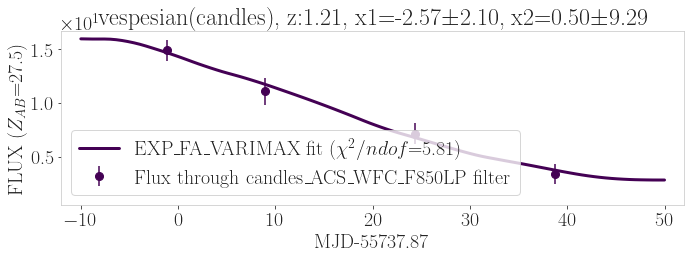

In [34]:
for j,sn in enumerate(sne_pass_cut):
    if sn not in pass_cosm_cuts:
        
        meta, surv, dat, result, fitted_model=lc_fit(sn) 
        
        lc_fit_plot(sn, surv, dat, result, fitted_model)     